# Cálculo matemático y gráficas

## Librerias

In [ ]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tabulate import tabulate

## Constantes

In [ ]:
def apply_plot_style():
    mpl.rcParams.update({
        # Tamaño por defecto de las figuras (más ancha que alta)
        "figure.figsize": (10, 4.5),  # ancho, alto en pulgadas

        # Texto
        "font.size": 11,
        "axes.titlesize": 14, "axes.titleweight": "bold",
        "axes.labelsize": 12, "axes.labelweight": "bold",

        # Ejes y spines
        "axes.spines.right": False, "axes.spines.top": False,
        "axes.linewidth": 1.2,
        "xtick.major.width": 1.0, "ytick.major.width": 1.0,

        # Grid sutil
        "axes.grid": True, "grid.alpha": 0.2, "grid.linestyle": "-",

        # Leyenda
        "legend.frameon": False,

        # Colores agradables y consistentes
        "axes.prop_cycle": plt.cycler(color=plt.cm.Set2.colors),

        # Márgenes automáticos
        "figure.autolayout": True
    })

In [ ]:
def ensureDir(dir_file):
    if not os.path.exists(dir_file):
        os.makedirs(dir_file)

In [ ]:
DATA_DIR = "../data"
LOGS_DIR = "./logs"
GRAPH_DIR = "../images/evidencia/graficas"

seq_files = {
    "impl1": os.path.join(DATA_DIR, "impl1", "sec.csv"),
    "impl2": os.path.join(DATA_DIR, "impl2", "sec.csv"),
    "impl3": os.path.join(DATA_DIR, "impl3", "sec.csv")
}

par_files = {
    "impl1": os.path.join(DATA_DIR, "impl1", "par.csv"),
    "impl2": os.path.join(DATA_DIR, "impl2", "par.csv"),
    "impl3": os.path.join(DATA_DIR, "impl3", "par.csv")
}

EXPECTED_COLS = [
    "implementation","mode","key","p","repetition","time_seconds",
    "iterations_done","found","finder_rank","timestamp","hostname",
    "phrase","text","out_bin"
]

ensureDir(LOGS_DIR)
ensureDir(GRAPH_DIR)
apply_plot_style()

## Funciones auxiliares

In [ ]:
def unifyCSV(files_dict, expected_cols=None):
    """
    files_dict: dict mapping implementation -> csv_path
    expected_cols: lista opcional de columnas que queremos garantizar en el DF final
    """
    if expected_cols is None:
        expected_cols = [
            "implementation","mode","key","p","repetition","time_seconds",
            "iterations_done","found","finder_rank","timestamp","hostname",
            "phrase","text","out_bin"
        ]

    dfs = []
    for impl, file in files_dict.items():
        try:
            df = pd.read_csv(
                file,
                parse_dates=["timestamp"],
                dtype={
                    "implementation": str, "mode": str, "key": str,
                    "p": "Int64", "repetition": "Int64",
                    "iterations_done": "Int64", "found": "Int64",
                    "finder_rank": "Int64", "hostname": str,
                    "phrase": str, "text": str, "out_bin": str
                },
                keep_default_na=False  # evita convertir campos vacíos a NaN
            )
        except Exception as e:
            print(f"ERROR leyendo {file}: {e}")
            continue

        # Forzar implementation con la llave del dict (si quieres preservar, quita esta línea)
        df["implementation"] = impl

        # Asegurar columnas esperadas (si faltan, se crean con valor vacío / nulo razonable)
        for col in expected_cols:
            if col not in df.columns:
                df[col] = "" if col in ["phrase", "text", "out_bin", "mode", "hostname"] else pd.NA

        # Normalizar tipos/valores mínimos
        df["text"] = df["text"].fillna("")  # importante: text vacío cuando mode=decrypt
        df["mode"] = df["mode"].fillna("decrypt")
        # asegurar numeric cast seguro (Int64 permite NA)
        df["p"] = pd.to_numeric(df["p"], errors="coerce").astype("Int64")
        df["repetition"] = pd.to_numeric(df["repetition"], errors="coerce").astype("Int64")
        df["time_seconds"] = pd.to_numeric(df["time_seconds"], errors="coerce").astype(float)
        df["found"] = pd.to_numeric(df["found"], errors="coerce").fillna(0).astype("Int64")

        dfs.append(df[expected_cols])

    if not dfs:
        return pd.DataFrame(columns=expected_cols)

    return pd.concat(dfs, ignore_index=True)

In [ ]:
def resumeData(df, log_filename="resumen.log", nombre="DataFrame"):
    log_path = os.path.join(LOGS_DIR, log_filename)
    df2 = df.copy()

    # Asegurar timestamp en datetime
    if "timestamp" in df2.columns:
        df2["timestamp"] = pd.to_datetime(df2["timestamp"], errors="coerce")

    with open(log_path, "w", encoding="utf-8") as f:
        f.write(f"===== Resumen: {nombre} =====\n")
        f.write(f"Tamaño: {df2.shape[0]} filas x {df2.shape[1]} columnas\n\n")

        f.write("Columnas y tipos de datos:\n")
        f.write(df2.dtypes.to_string())
        f.write("\n\n")

        f.write("Primeras 5 filas:\n")
        f.write(df2.head().to_string())
        f.write("\n\n")

        f.write("Estadísticas básicas (numéricas):\n")
        f.write(df2.describe().to_string())
        f.write("\n\n")

        # Conteos por implementation y por mode
        f.write("Conteo por implementation:\n")
        f.write(df2["implementation"].value_counts().to_string())
        f.write("\n\n")

        if "mode" in df2.columns:
            f.write("Conteo por mode:\n")
            f.write(df2["mode"].value_counts().to_string())
            f.write("\n\n")

        # Filas con text vacío (útil para saber cuántas entradas paralelas)
        if "text" in df2.columns:
            empty_text = (df2["text"].astype(str) == "").sum()
            f.write(f"Filas con 'text' vacío: {empty_text}\n\n")

        # Muestra algunas filas donde text está vacío y mode==decrypt (opcional)
        if set(["text","mode"]).issubset(df2.columns):
            mask = (df2["text"].astype(str) == "") & (df2["mode"] == "decrypt")
            f.write("Ejemplos (mode=decrypt y text vacío) - primeras 10:\n")
            f.write(df2.loc[mask].head(10).to_string())
            f.write("\n")

    print(f"Resumen guardado en: {log_path}")

## Cálculos principales

In [ ]:
def computeAverageTimeSec(dfSec, implName, key=None):
    """
    Calcula el tiempo secuencial promedio para una implementación y llave opcional.
    """
    df = dfSec[dfSec['implementation'] == implName]
    if key is not None:
        df = df[df['key'] == key]
    return df['time_seconds'].mean()

In [ ]:
def computeAverageTimePar(dfPar, implName, key=None, p=None):
    """
    Calcula el tiempo paralelo promedio para una implementación, llave y número de procesos opcional.
    """
    df = dfPar[dfPar['implementation'] == implName]
    if key is not None:
        df = df[df['key'] == key]
    if p is not None:
        df = df[df['p'] == p]
    return df['time_seconds'].mean()

In [ ]:
def computeSpeedup(tSec, tPar):
    """
    Calcula el speedup: S = T_s / T_p
    """
    return tSec / tPar if tPar > 0 else np.nan

In [ ]:
def computeEfficiency(speedup, p):
    """
    Calcula la eficiencia: E = S / p
    """
    return speedup / p if p > 0 else np.nan

In [ ]:
def estimateFracSec(speedup, p):
    """
    Estima la fracción secuencial usando la Ley de Amdahl: f ≈ (1/S - 1/p)/(1 - 1/p)
    """
    if speedup <= 0 or p <= 1:
        return np.nan
    return (1/speedup - 1/p) / (1 - 1/p)

In [ ]:
def generatePerformanceDF(dfSec, dfPar, logFilename="performance.log"):
    """
    Genera un DataFrame con métricas principales (T_s, T_p, Speedup, Efficiency, FracSec)
    para todas las implementaciones, llaves y valores de p disponibles.
    Guarda un resumen en LOGS_DIR con formato tabular.
    """
    results = []

    implementations = dfSec['implementation'].unique()

    for impl in implementations:
        keys = dfSec[dfSec['implementation'] == impl]['key'].unique()
        ps = dfPar[dfPar['implementation'] == impl]['p'].unique()

        for key in keys:
            tSec = computeAverageTimeSec(dfSec, impl, key)
            for p_val in ps:
                subsetPar = dfPar[(dfPar['implementation'] == impl) & 
                                  (dfPar['key'] == key) & 
                                  (dfPar['p'] == p_val)]
                if subsetPar.empty:
                    # Si no hay datos, saltar
                    continue

                tPar = computeAverageTimePar(dfPar, impl, key, p_val)
                speedup = computeSpeedup(tSec, tPar)
                efficiency = computeEfficiency(speedup, p_val)
                fracSec = estimateFracSec(speedup, p_val)

                results.append({
                    "implementation": impl,
                    "key": key,
                    "p": p_val,
                    "T_s": tSec,
                    "T_p": tPar,
                    "Speedup": speedup,
                    "Efficiency": efficiency,
                    "FracSec": fracSec
                })

    dfResults = pd.DataFrame(results)

    logPath = os.path.join("./logs", logFilename)
    with open(logPath, "w", encoding="utf-8") as f:
        f.write(f"===== Resumen de rendimiento =====\n")
        f.write(f"Tamaño: {dfResults.shape[0]} filas x {dfResults.shape[1]} columnas\n\n")
        f.write(tabulate(dfResults, headers="keys", tablefmt="grid", showindex=False))

    print(f"Resumen guardado en: {logPath}")
    return dfResults

In [ ]:
def generatePerformanceDF_with_baseline(dfSec, dfPar, impl_baseline="impl1", logFilename="perf_summary.log"):
    results = []

    # Keys disponibles para el baseline
    keys = (dfSec.loc[dfSec['implementation'] == impl_baseline, 'key']
                  .astype(str).unique())

    # Precalcular T_s por key (baseline)
    ts_by_key = {
        k: dfSec[(dfSec['implementation'] == impl_baseline) & (dfSec['key'].astype(str) == str(k))]
               ['time_seconds'].mean()
        for k in keys
    }

    # Implementaciones paralelas a comparar (todas las presentes)
    impls_par = dfPar['implementation'].unique()

    for impl in impls_par:
        df_impl = dfPar[dfPar['implementation'] == impl]
        ps = pd.Series(df_impl['p'].unique()).dropna().tolist()
        for k in keys:
            # subconjunto paralelo por key
            g = df_impl[df_impl['key'].astype(str) == str(k)]
            if g.empty:
                continue
            for p_val in sorted(pd.Series(g['p'].unique()).dropna()):
                tPar = g[g['p'] == p_val]['time_seconds'].mean()
                tSec = ts_by_key.get(k, np.nan)
                if pd.isna(tSec) or pd.isna(tPar):
                    continue
                S = computeSpeedup(tSec, tPar)
                E = computeEfficiency(S, p_val)
                f = estimateFracSec(S, p_val)
                results.append({
                    "implementation": impl,
                    "key": k,
                    "p": p_val,
                    "T_s": tSec,
                    "T_p": tPar,
                    "Speedup": S,
                    "Efficiency": E,
                    "FracSec": f,
                    "baseline_impl": impl_baseline
                })

    dfResults = pd.DataFrame(results)

    logPath = os.path.join(LOGS_DIR, logFilename)
    with open(logPath, "w", encoding="utf-8") as f:
        f.write(f"===== Resumen de rendimiento (baseline={impl_baseline}) =====\n")
        f.write(f"Tamaño: {dfResults.shape[0]} filas x {dfResults.shape[1]} columnas\n\n")
        f.write(tabulate(dfResults, headers="keys", tablefmt="grid", showindex=False))
    print(f"Resumen guardado en: {logPath}")
    return dfResults

## Gráficas

In [ ]:
def plotExecutionTimeVsP(dfResults, savePath=None):
    """
    Gráfico de T_p vs número de procesos p para cada implementación.
    """
    fig, ax = plt.subplots()

    for (impl, key), g in (dfResults
                           .sort_values("p")
                           .groupby(["implementation","key"], sort=False)):
        ax.plot(g["p"], g["T_p"], marker="o", linewidth=2,
                label=f"{impl} · key={key}")

    ax.set_xlabel('Número de procesos (p)')
    ax.set_ylabel('Tiempo paralelo T_p (s)')
    ax.set_title('Tiempo de ejecución vs número de procesos')
    ax.set_xticks(sorted(dfResults["p"].unique()))
    ax.margins(x=0.02, y=0.05)
    # Leyenda afuera para no tapar
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title="Serie")
    fig.tight_layout()
    if savePath: fig.savefig(savePath, bbox_inches='tight', dpi=200)
    plt.show()

In [ ]:
def plotSpeedupVsP(dfResults, savePath=None):
    """
    Gráfico de Speedup vs número de procesos p, con línea ideal S=p.
    """
    fig, ax = plt.subplots()

    ps_sorted = sorted(dfResults["p"].unique())
    ax.plot(ps_sorted, ps_sorted, linestyle='--', linewidth=1.5, label='Ideal S=p', color='0.2')

    for (impl, key), g in (dfResults
                           .sort_values("p")
                           .groupby(["implementation","key"], sort=False)):
        ax.plot(g["p"], g["Speedup"], marker="o", linewidth=2,
                label=f"{impl} · key={key}")

    ax.set_xlabel('Número de procesos (p)')
    ax.set_ylabel('Speedup S')
    ax.set_title('Speedup vs número de procesos')
    ax.set_xticks(ps_sorted)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title="Serie")
    fig.tight_layout()
    if savePath: fig.savefig(savePath, bbox_inches='tight', dpi=200)
    plt.show()

In [ ]:
def plotEfficiencyVsP(dfResults, savePath=None):
    """
    Gráfico de eficiencia vs número de procesos p para cada implementación.
    """
    fig, ax = plt.subplots()

    for (impl, key), g in (dfResults
                           .sort_values("p")
                           .groupby(["implementation","key"], sort=False)):
        ax.plot(g["p"], g["Efficiency"], marker="o", linewidth=2,
                label=f"{impl} · key={key}")

    ax.axhline(1.0, linestyle='--', linewidth=1, color='0.5')
    ax.axhline(0.5, linestyle=':', linewidth=1, color='0.5')

    ax.set_xlabel('Número de procesos (p)')
    ax.set_ylabel('Eficiencia E')
    ax.set_title('Eficiencia vs número de procesos')
    ax.set_xticks(sorted(dfResults["p"].unique()))
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title="Serie")
    fig.tight_layout()
    if savePath: fig.savefig(savePath, bbox_inches='tight', dpi=200)
    plt.show()

In [ ]:
def plotBoxplotTimeByKey(dfPar, savePath=None):
    """
    Boxplot de tiempos paralelos por key y por implementación.
    """
    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(
        x='key', y='time_seconds', hue='implementation', data=dfPar,
        linewidth=1.2, fliersize=2, dodge=True, ax=ax, palette='Set2'
    )

    ax.set_xlabel('Key')
    ax.set_ylabel('Tiempo paralelo T_p (s)')
    ax.set_title('Distribución de tiempo paralelo por key')
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), title="impl")
    fig.tight_layout()
    if savePath: fig.savefig(savePath, bbox_inches='tight', dpi=200)
    plt.show()

In [ ]:
def plotComparisonSequentialVsParallel(dfResults, savePath=None):
    """
    Barras agrupadas de T_s vs T_p promedio por implementación.
    """
    dfAvg = (dfResults.groupby('implementation')[['T_s','T_p']]
             .mean().reset_index())

    fig, ax = plt.subplots()
    width = 0.38
    x = range(len(dfAvg))
    ax.bar([i - width/2 for i in x], dfAvg['T_s'], width, label='T_s')
    ax.bar([i + width/2 for i in x], dfAvg['T_p'], width, label='T_p')
    ax.set_xticks(list(x))
    ax.set_xticklabels(dfAvg['implementation'])
    ax.set_ylabel('Tiempo promedio (s)')
    ax.set_title('Comparación secuencial vs paralelo')
    ax.legend(title=None)
    for i, v in enumerate(dfAvg['T_s']):
        ax.text(i - width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=9)
    for i, v in enumerate(dfAvg['T_p']):
        ax.text(i + width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=9)
    fig.tight_layout()
    if savePath: fig.savefig(savePath, bbox_inches='tight', dpi=200)
    plt.show()

## Pipeline

In [ ]:
df_sec = unifyCSV(seq_files)
df_par = unifyCSV(par_files)
df_sec = df_sec[df_sec['mode'] == 'decrypt']
df_par = df_par[(df_par['mode'] == 'decrypt') & (df_par['p'] > 0)]
df_par = df_par[df_par['found'] == 1]

In [ ]:
resumeData(df=df_sec, log_filename="secuencial_resumen.log", nombre="Secuencial unificado")
resumeData(df=df_par, log_filename="paralelo_resumen.log", nombre="Paralelo unificado")

Resumen guardado en: ./logs\secuencial_resumen.log
Resumen guardado en: ./logs\paralelo_resumen.log


### Enfoque A - Comparación individual por implementación

Cada implementación se compara contra su propia versión secuencial. Permite evaluar la eficiencia del paralelismo interno de cada diseño (impl1, impl2, impl3).

In [ ]:
perfDF = generatePerformanceDF(df_sec, df_par, logFilename="perf_summary.log")

Resumen guardado en: ./logs\perf_summary.log


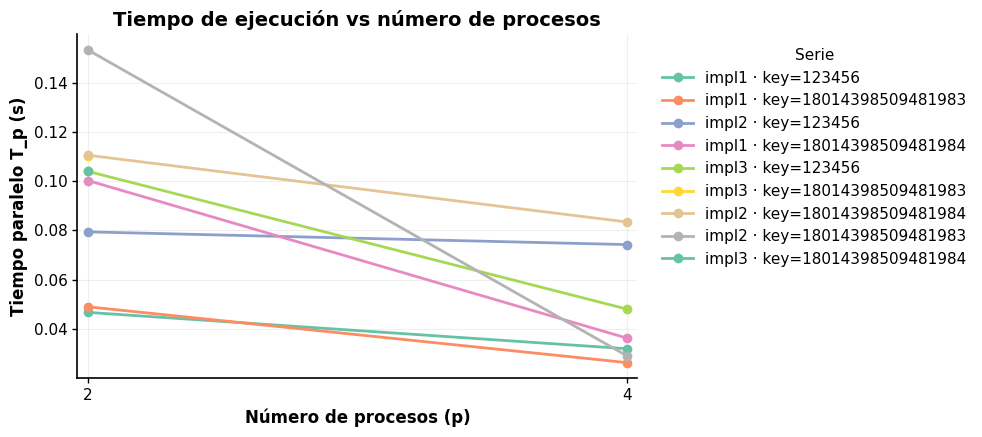

In [ ]:
plotExecutionTimeVsP(perfDF, f"{GRAPH_DIR}/ea_exec_time_vs_p.png")

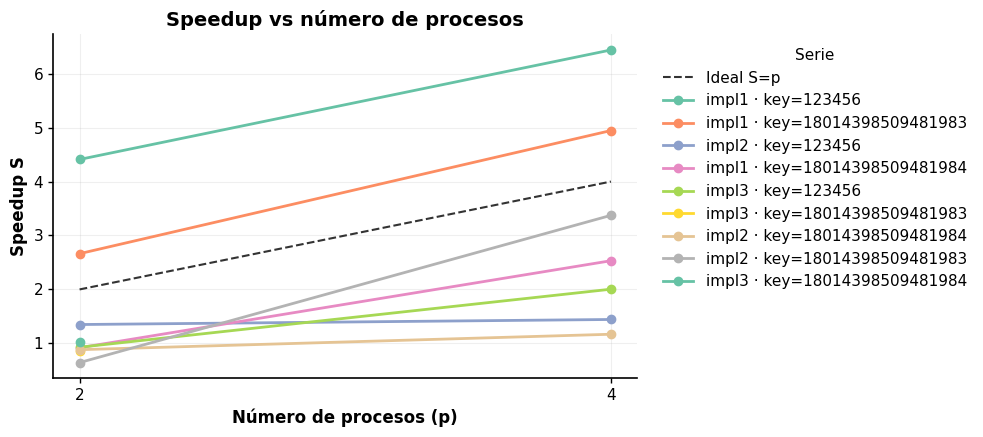

In [ ]:
plotSpeedupVsP(perfDF, f"{GRAPH_DIR}/ea_speedup_vs_p.png")

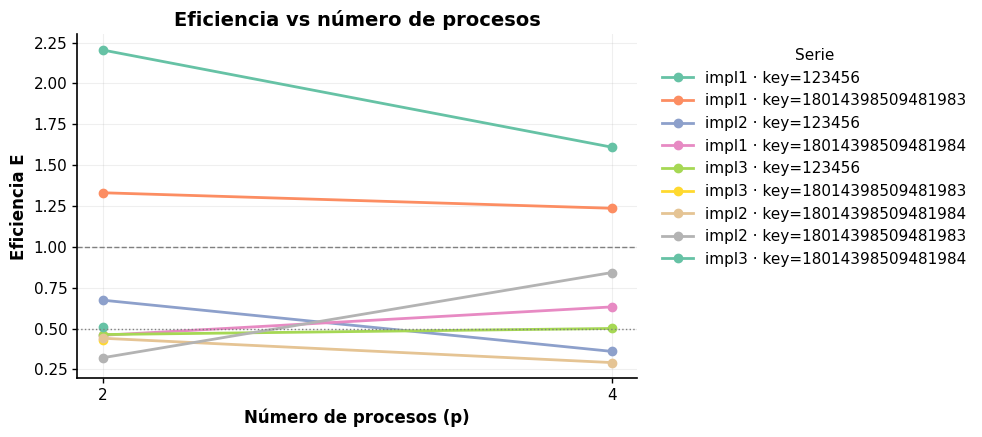

In [ ]:
plotEfficiencyVsP(perfDF, f"{GRAPH_DIR}/ea_efficiency_vs_p.png")

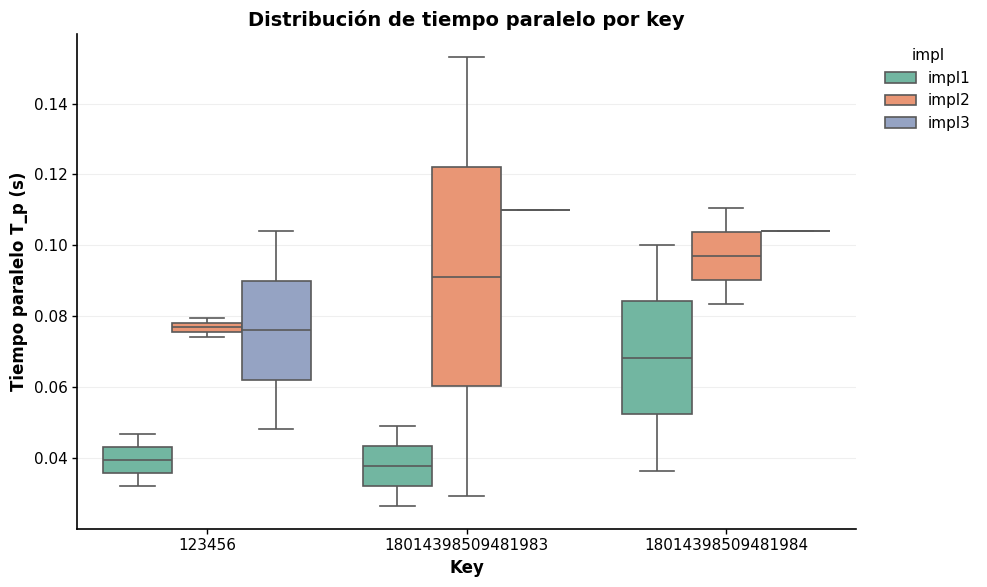

In [ ]:
plotBoxplotTimeByKey(df_par, f"{GRAPH_DIR}/ea_boxplot_time_by_key.png")

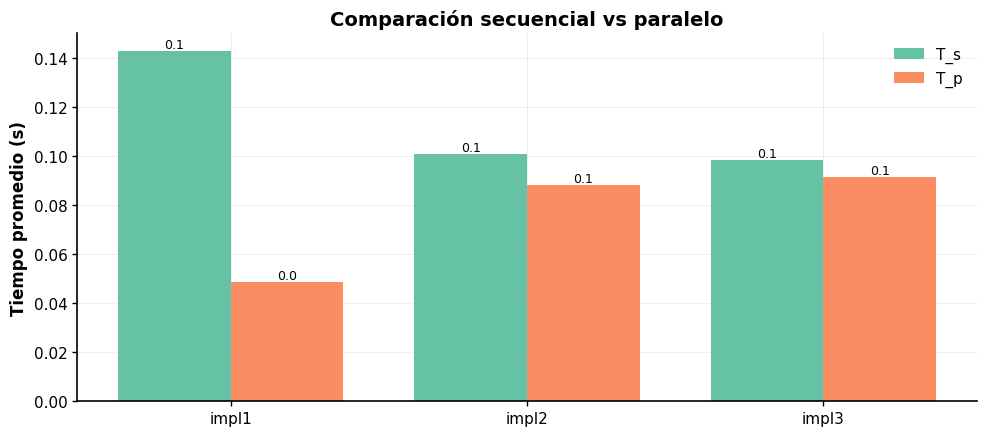

In [ ]:
plotComparisonSequentialVsParallel(perfDF, f"{GRAPH_DIR}/ea_seq_vs_par.png")

### Enfoque B - comparación con baseline fijo

Usa el tiempo secuencial de impl1 como línea base común para medir la aceleración lograda por todas las implementaciones paralelas, permitiendo comparar su desempeño relativo frente al mismo punto de referencia.

In [ ]:
perfDF2 = generatePerformanceDF_with_baseline(df_sec, df_par, impl_baseline="impl1", logFilename="perf_summary.log")

Resumen guardado en: ./logs\perf_summary.log


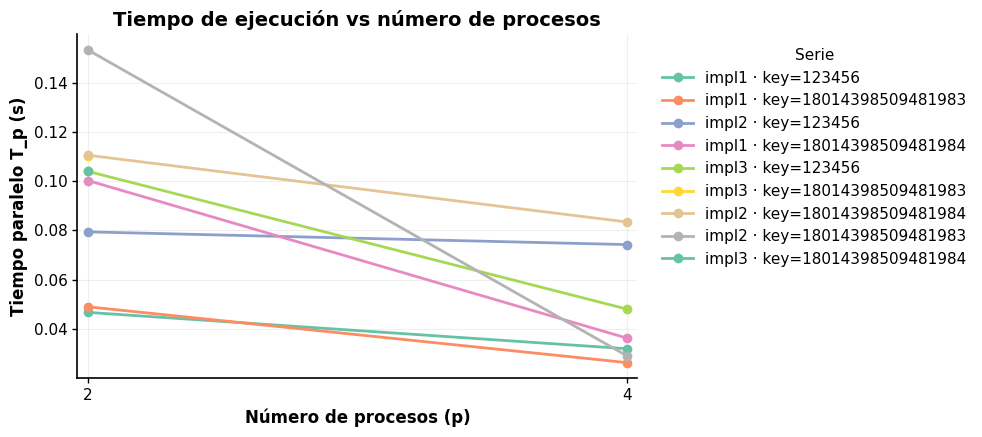

In [ ]:
plotExecutionTimeVsP(perfDF2, f"{GRAPH_DIR}/eb_exec_time_vs_p.png")

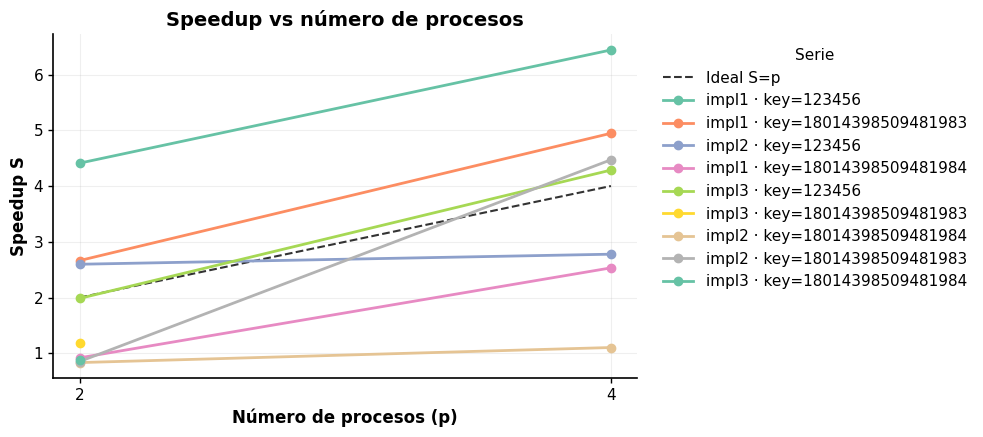

In [ ]:
plotSpeedupVsP(perfDF2, f"{GRAPH_DIR}/eb_speedup_vs_p.png")

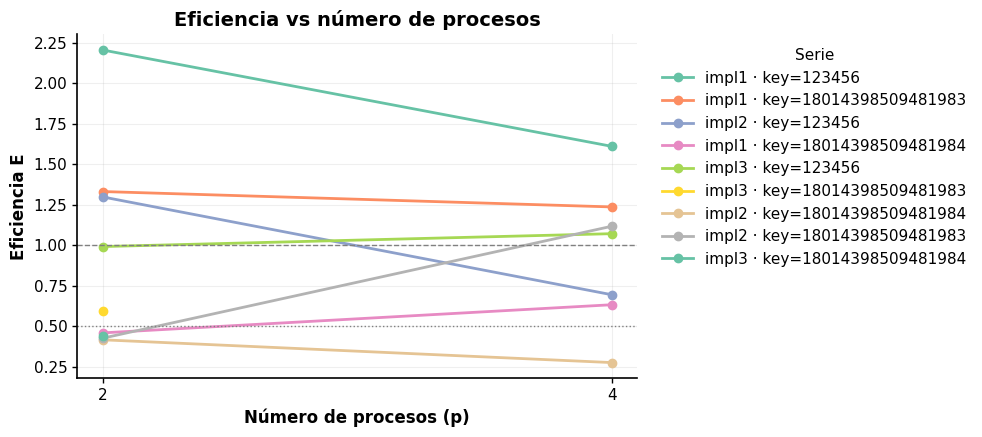

In [ ]:
plotEfficiencyVsP(perfDF2, f"{GRAPH_DIR}/eb_efficiency_vs_p.png")

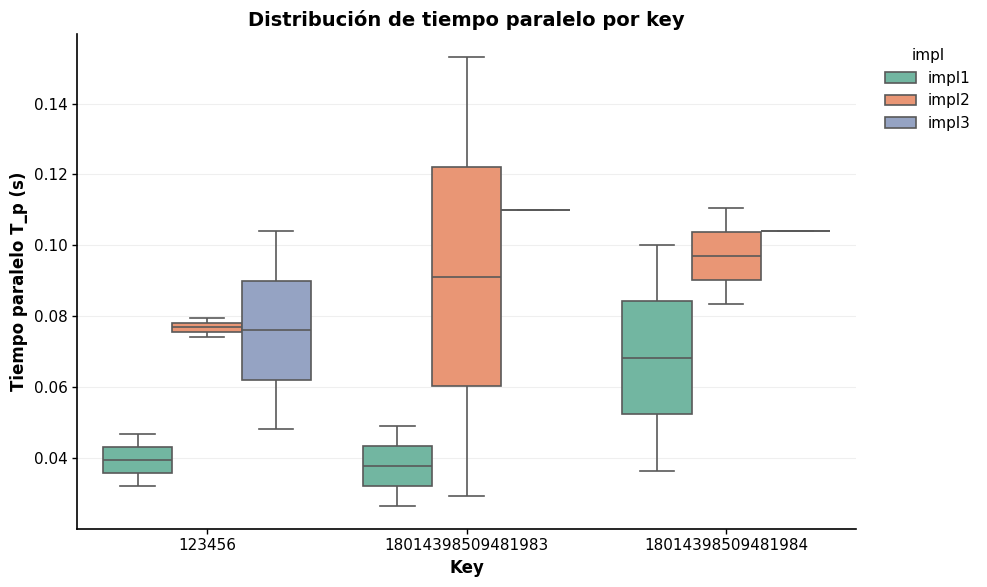

In [ ]:
plotBoxplotTimeByKey(df_par, f"{GRAPH_DIR}/eb_boxplot_time_by_key.png")

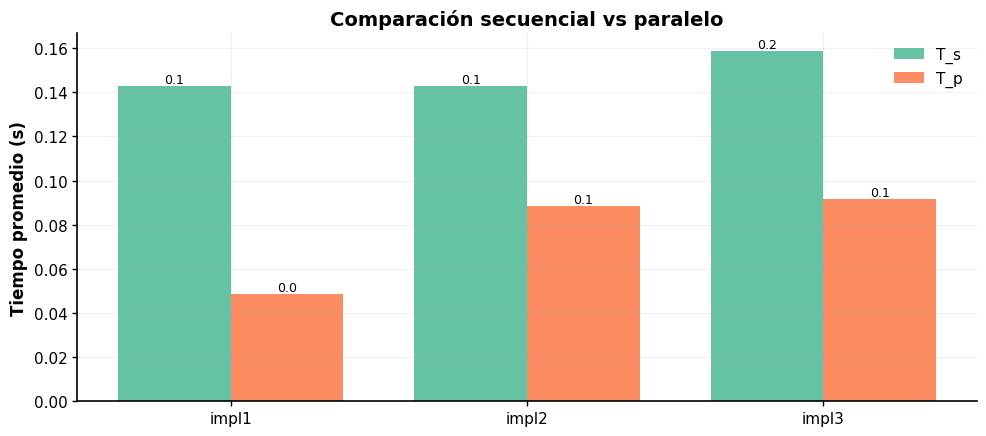

In [ ]:
plotComparisonSequentialVsParallel(perfDF2, f"{GRAPH_DIR}/eb_seq_vs_par.png")